# **Advance Topics in Machine Learning**
## **Assignment 0 - Introduction**
---

### **Task 1: Inner Workings of ResNet-152**

In [1]:
# Importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
import copy
from pathlib import Path
import umap

# Checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**1. Baseline Setup**

(a) Use a pre-trained ResNet-152 from PyTorch.

In [2]:
# Loading pretrained model
weights = ResNet152_Weights.DEFAULT
model = resnet152(weights=weights)
model = model.to(device)

(b) Replace the final classification layer to match a smaller dataset such as CIFAR-10.

In [3]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model.fc = model.fc.to(device)

(c) Train only the classification head while freezing the rest of the backbone.

In [4]:
# Freezing backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreezing only the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Only head parameters will update - using filter to get only trainable params
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

(d) Record training and validation performance for a few epochs.

In [5]:
# CIFAR-10 data loading
transform = transforms.Compose([
    transforms.Resize(224), # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
val_dataset   = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader    = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(tqdm(loader, desc="Training")):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in tqdm(loader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

In [7]:
def run_simple_training(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")
    state = copy.deepcopy(model.state_dict())
    return results, state

def plot_results(results, out_path="outputs/baseline_metrics.png"):
    Path("outputs").mkdir(exist_ok=True)
    epochs = range(1, len(results["train_loss"]) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(epochs, results["train_loss"], "-o", label="train")
    ax1.plot(epochs, results["test_loss"], "-s", label="test")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.set_title("Loss")
    ax1.grid(True); ax1.legend()
    ax2.plot(epochs, results["train_acc"], "-o", label="train")
    ax2.plot(epochs, results["test_acc"], "-s", label="test")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy (%)"); ax2.set_title("Accuracy")
    ax2.grid(True); ax2.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()


Epoch 1/5


Evaluating: 100%|██████████| 313/313 [01:04<00:00,  4.84it/s]


Train Loss: 0.6658, Train Acc: 78.64%
Test  Loss: 0.5052, Test  Acc: 83.43%

Epoch 2/5


Evaluating: 100%|██████████| 313/313 [01:08<00:00,  4.58it/s]


Train Loss: 0.5005, Train Acc: 83.07%
Test  Loss: 0.4681, Test  Acc: 84.61%

Epoch 3/5


Evaluating: 100%|██████████| 313/313 [01:05<00:00,  4.80it/s]


Train Loss: 0.4661, Train Acc: 84.32%
Test  Loss: 0.4660, Test  Acc: 84.15%

Epoch 4/5


Evaluating: 100%|██████████| 313/313 [01:05<00:00,  4.78it/s]


Train Loss: 0.4468, Train Acc: 84.88%
Test  Loss: 0.4617, Test  Acc: 84.71%

Epoch 5/5


Evaluating: 100%|██████████| 313/313 [01:05<00:00,  4.78it/s]


Train Loss: 0.4243, Train Acc: 85.52%
Test  Loss: 0.4630, Test  Acc: 84.48%


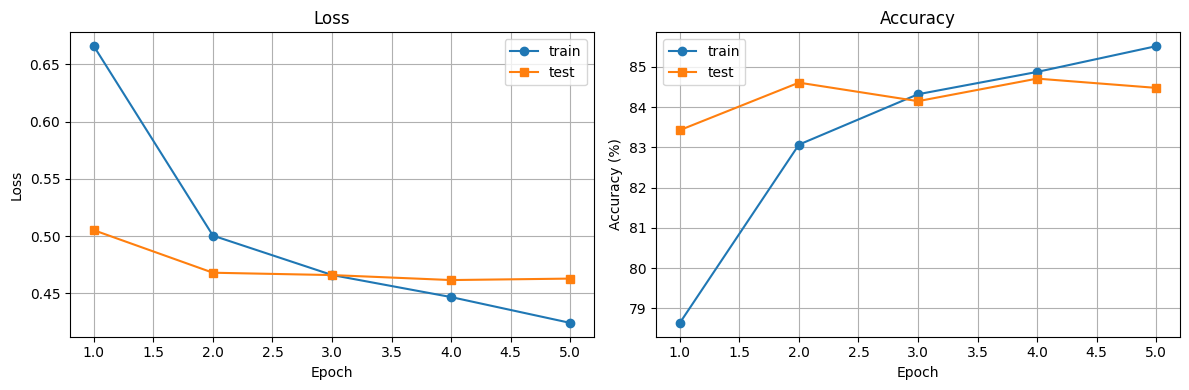

In [8]:
baseline_results, baseline_model_state = run_simple_training(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)
plot_results(baseline_results)

**2. Residual Connections in Practice**

(a) Disable skip connections in a few selected residual blocks and re-train the modified network head.

In [ ]:
class ModifiedBottleneck(nn.Module):
    """Modified Bottleneck block with option to disable skip connection"""
    expansion = 4

    def __init__(self, original_block, disable_skip=False):
        super(ModifiedBottleneck, self).__init__()
        self.conv1 = original_block.conv1
        self.bn1 = original_block.bn1
        self.conv2 = original_block.conv2
        self.bn2 = original_block.bn2
        self.conv3 = original_block.conv3
        self.bn3 = original_block.bn3
        self.relu = original_block.relu
        self.downsample = original_block.downsample
        self.disable_skip = disable_skip
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if not self.disable_skip:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
            
        out = self.relu(out)
        return out

def disable_skip_connections(model, layers_to_modify=['layer3', 'layer4']):
    """Disable skip connections in specified layers"""
    modified_model = copy.deepcopy(model)
    
    for layer_name in layers_to_modify:
        if hasattr(modified_model, layer_name):
            layer = getattr(modified_model, layer_name)
            for i, block in enumerate(layer):
                # Only modifying first few blocks in each layer
                if i < 2:  # Modifying first 2 blocks
                    modified_block = ModifiedBottleneck(block, disable_skip=True)
                    layer[i] = modified_block
                    print(f"Disabled skip connection in {layer_name}.{i}")
    
    return modified_model

# Creating model with disabled skip connections
model_no_skip = disable_skip_connections(model)
model_no_skip = model_no_skip.to(device)

# Resetting the final layer and freeze backbone
model_no_skip.fc = nn.Linear(num_features, 10).to(device)
for param in model_no_skip.parameters():
    param.requires_grad = False
for param in model_no_skip.fc.parameters():
    param.requires_grad = True

# Setting up optimizer for modified model
optimizer_no_skip = torch.optim.Adam(model_no_skip.fc.parameters(), lr=1e-3)

Disabled skip connection in layer3.0
Disabled skip connection in layer3.1
Disabled skip connection in layer4.0
Disabled skip connection in layer4.1


(b) Compare training dynamics and validation accuracy with the baseline.


Epoch 1/5


Evaluating: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s]


Train Loss: 2.2956, Train Acc: 12.36%
Test  Loss: 2.2893, Test  Acc: 13.38%

Epoch 2/5


Evaluating: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s]


Train Loss: 2.2869, Train Acc: 12.89%
Test  Loss: 2.2816, Test  Acc: 13.95%

Epoch 3/5


Evaluating: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s]


Train Loss: 2.2843, Train Acc: 13.60%
Test  Loss: 2.2784, Test  Acc: 13.92%

Epoch 4/5


Evaluating: 100%|██████████| 313/313 [01:06<00:00,  4.70it/s]


Train Loss: 2.2808, Train Acc: 13.81%
Test  Loss: 2.2777, Test  Acc: 14.35%

Epoch 5/5


Evaluating: 100%|██████████| 313/313 [01:08<00:00,  4.55it/s]


Train Loss: 2.2776, Train Acc: 13.85%
Test  Loss: 2.2706, Test  Acc: 14.58%


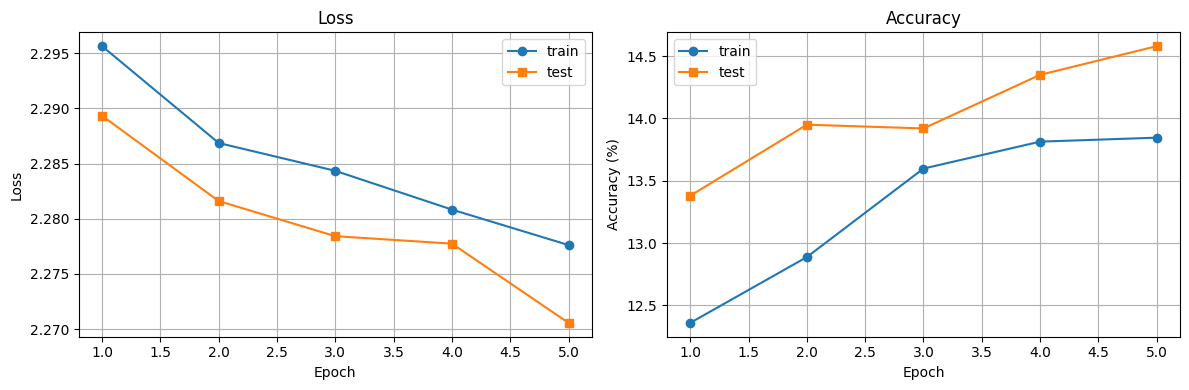

In [10]:
modified_results, modified_model_state = run_simple_training(model_no_skip, train_loader, val_loader, criterion, optimizer_no_skip, num_epochs=5, device=device)
plot_results(modified_results)

**3. Feature Hierarchies and Representations**

(a) Collect features from early, middle, and late layers of the network.

In [11]:
# Load the baseline model for feature extraction
model.load_state_dict(baseline_model_state)
model.eval()

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.features = {}
        
    def forward(self, x):
        # Early layer (after first conv block)
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        early_features = x.clone()
        
        # Layer 1
        x = self.model.layer1(x)
        
        # Middle layer (after layer 2)
        x = self.model.layer2(x)
        middle_features = x.clone()
        
        # Layer 3 and 4
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        
        # Late layer (before final pooling)
        late_features = x.clone()
        
        # Final classification
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        
        return {
            'early': early_features,
            'middle': middle_features, 
            'late': late_features,
            'output': x
        }

# Create feature extractor
feature_extractor = FeatureExtractor(model).to(device)

def extract_features_and_labels(model, loader, max_batches=10):
    """Extract features and labels from specified layers"""
    model.eval()
    
    early_features = []
    middle_features = []
    late_features = []
    labels = []
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loader):
            if batch_idx >= max_batches:
                break
                
            data = data.to(device)
            features = model(data)
            
            # Global average pooling for each feature level
            early_feat = F.adaptive_avg_pool2d(features['early'], (1, 1)).squeeze()
            middle_feat = F.adaptive_avg_pool2d(features['middle'], (1, 1)).squeeze()  
            late_feat = F.adaptive_avg_pool2d(features['late'], (1, 1)).squeeze()
            
            early_features.append(early_feat.cpu().numpy())
            middle_features.append(middle_feat.cpu().numpy())
            late_features.append(late_feat.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    
    return {
        'early': np.vstack(early_features),
        'middle': np.vstack(middle_features),
        'late': np.vstack(late_features),
        'labels': np.array(labels)
    }

# Extract features from test set
print("Extracting features from different layers...")
features_data = extract_features_and_labels(feature_extractor, val_loader, max_batches=20)

print(f"Early features shape: {features_data['early'].shape}")
print(f"Middle features shape: {features_data['middle'].shape}")
print(f"Late features shape: {features_data['late'].shape}")
print(f"Labels shape: {features_data['labels'].shape}")

Extracting features from different layers...
Early features shape: (640, 64)
Middle features shape: (640, 512)
Late features shape: (640, 2048)
Labels shape: (640,)


(b) Visualize these features using dimensionality reduction (t-SNE or UMAP).

Visualizing features with t-SNE...


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_4812\4270305997.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


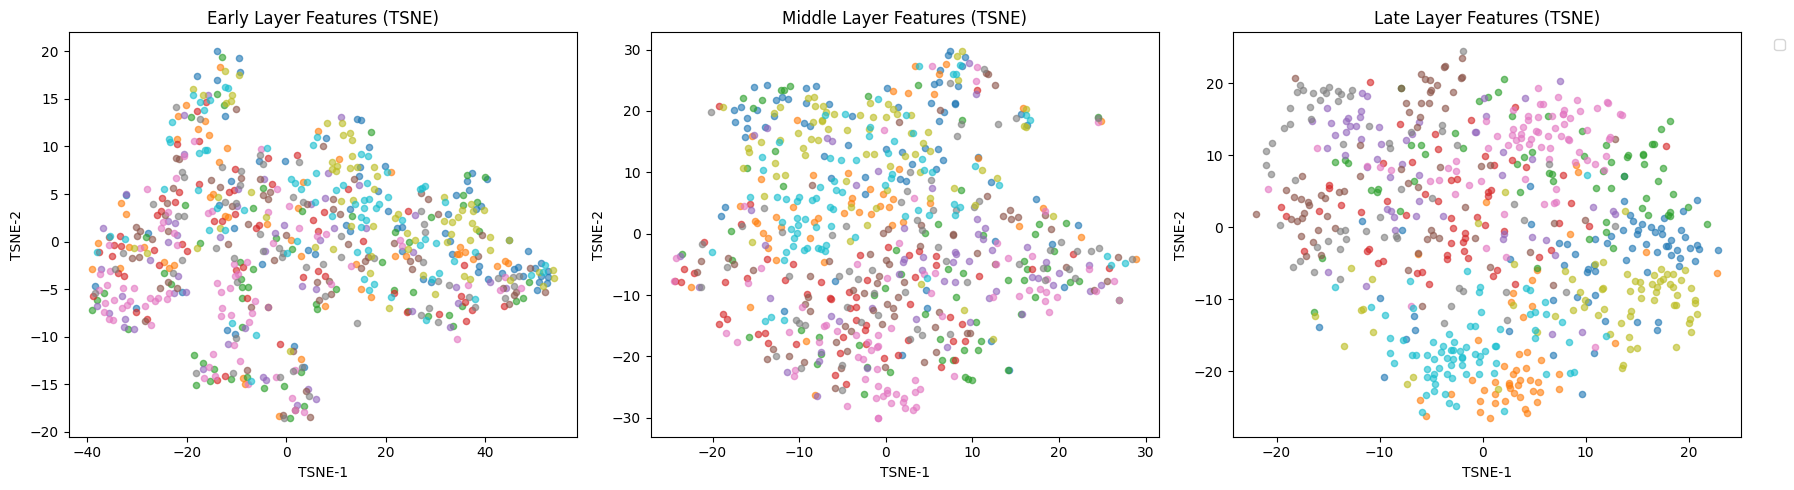

Visualizing features with UMAP...


C:\Users\Abdullah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Abdullah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Abdullah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Abdullah\AppData\Local\Temp\ipykernel_4812\4270305997.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignore

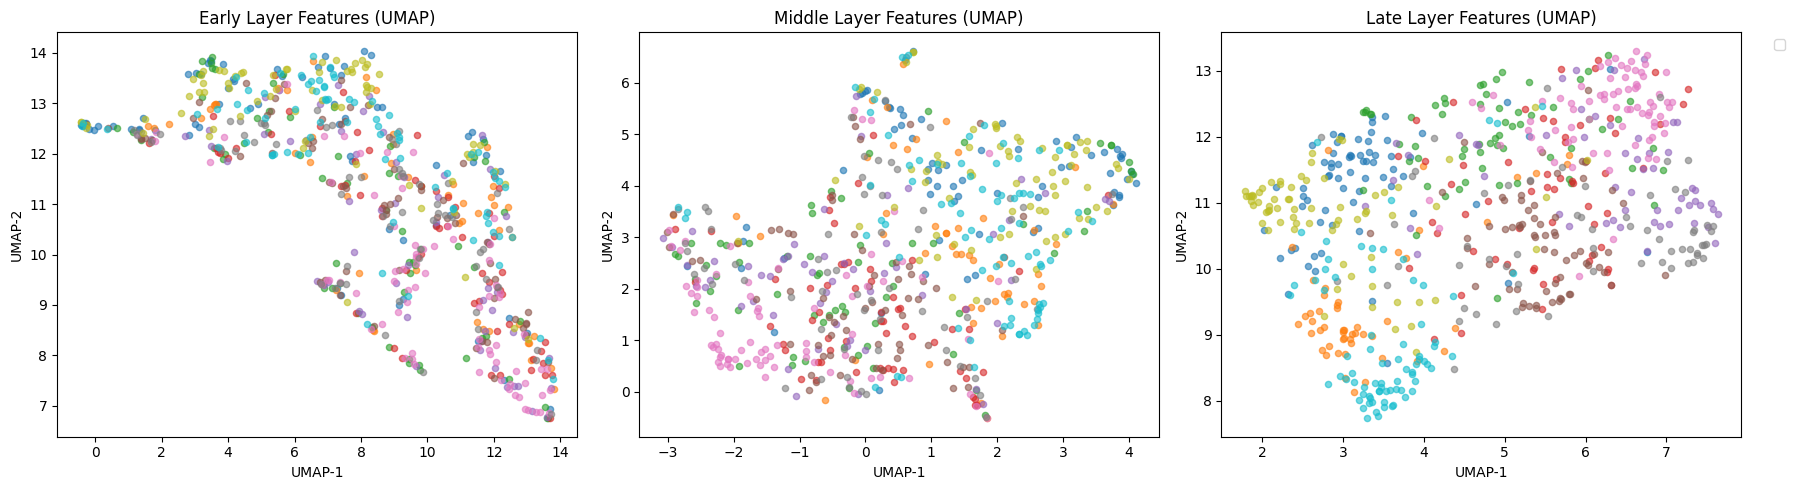

In [12]:
def visualize_features(features_dict, labels, method='tsne', n_samples=1000):
    """Visualize features using t-SNE or UMAP"""
    
    # Sample data if too large
    if len(labels) > n_samples:
        indices = np.random.choice(len(labels), n_samples, replace=False)
        sampled_features = {k: v[indices] for k, v in features_dict.items() if k != 'labels'}
        sampled_labels = labels[indices]
    else:
        sampled_features = {k: v for k, v in features_dict.items() if k != 'labels'}
        sampled_labels = labels
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    layer_names = ['early', 'middle', 'late']
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, layer in enumerate(layer_names):
        features = sampled_features[layer]
        
        # Apply dimensionality reduction
        if method == 'tsne':
            # First reduce to 50D with PCA, then t-SNE
            if features.shape[1] > 50:
                pca = PCA(n_components=50)
                features_reduced = pca.fit_transform(features)
            else:
                features_reduced = features
            
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            features_2d = tsne.fit_transform(features_reduced)
            
        elif method == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
            features_2d = reducer.fit_transform(features)
        
        # Plot
        ax = axes[idx]
        for class_idx in range(10):
            mask = sampled_labels == class_idx
            if np.any(mask):
                ax.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                          c=[colors[class_idx]], 
                          alpha=0.6, s=20)
        
        ax.set_title(f'{layer.capitalize()} Layer Features ({method.upper()})')
        ax.set_xlabel(f'{method.upper()}-1')
        ax.set_ylabel(f'{method.upper()}-2')
        
        if idx == 2:  # Only show legend on the last plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Visualize with t-SNE
print("Visualizing features with t-SNE...")
visualize_features(features_data, features_data['labels'], method='tsne')

# Visualize with UMAP  
print("Visualizing features with UMAP...")
visualize_features(features_data, features_data['labels'], method='umap')

**4. Transfer Learning and Generalization**

(a) Fine-tune the model on a dataset different from ImageNet.

(b) Compare performance between: (a) using ImageNet-pretrained weights, and (b) training from random
initialization.

In [13]:
# Create model with random initialization
model_random = resnet152(weights=None)  # No pre-trained weights
model_random.fc = nn.Linear(model_random.fc.in_features, 10)
model_random = model_random.to(device)

# Freeze backbone for random init model too (fair comparison)
for param in model_random.parameters():
    param.requires_grad = False
for param in model_random.fc.parameters():
    param.requires_grad = True

# Setup optimizer
optimizer_random = torch.optim.Adam(model_random.fc.parameters(), lr=1e-3)

# Train random initialization model
random_results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

print("Training ResNet-152 with random initialization...")
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/{5}")
    
    # Train
    train_loss, train_acc = train_epoch(model_random, train_loader, criterion, optimizer_random, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model_random, val_loader, criterion, device)
    
    # Store results
    random_results['train_loss'].append(train_loss)
    random_results['train_acc'].append(train_acc)
    random_results['test_loss'].append(test_loss)
    random_results['test_acc'].append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Training ResNet-152 with random initialization...

Epoch 1/5


Evaluating: 100%|██████████| 313/313 [01:08<00:00,  4.55it/s]


Train Loss: 2.4229, Train Acc: 13.61%
Test Loss: 2.3667, Test Acc: 13.51%

Epoch 2/5


Evaluating: 100%|██████████| 313/313 [01:08<00:00,  4.59it/s]


Train Loss: 2.3953, Train Acc: 15.22%
Test Loss: 2.3389, Test Acc: 16.71%

Epoch 3/5


Evaluating: 100%|██████████| 313/313 [01:07<00:00,  4.64it/s]


Train Loss: 2.3678, Train Acc: 16.31%
Test Loss: 2.5056, Test Acc: 18.81%

Epoch 4/5


Evaluating: 100%|██████████| 313/313 [01:07<00:00,  4.62it/s]


Train Loss: 2.3510, Train Acc: 16.87%
Test Loss: 2.3418, Test Acc: 15.91%

Epoch 5/5


Evaluating: 100%|██████████| 313/313 [01:05<00:00,  4.81it/s]

Train Loss: 2.3262, Train Acc: 17.31%
Test Loss: 2.3414, Test Acc: 19.51%


(c) Experiment with fine-tuning only the final block versus the full backbone.

In [ ]:
# Create model for full backbone fine-tuning
model_full_finetune = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
model_full_finetune.fc = nn.Linear(model_full_finetune.fc.in_features, 10)
model_full_finetune = model_full_finetune.to(device)

# Unfreeze all parameters
for param in model_full_finetune.parameters():
    param.requires_grad = True

# Use lower learning rate for full fine-tuning
optimizer_full = torch.optim.Adam(model_full_finetune.parameters(), lr=1e-4)

# Train with full fine-tuning (fewer epochs due to longer training time)
full_finetune_results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
num_epochs_full = 3  # Reduced epochs for full fine-tuning

print("Training ResNet-152 with full backbone fine-tuning...")
for epoch in range(num_epochs_full):
    print(f"\nEpoch {epoch+1}/{num_epochs_full}")
    
    # Train
    train_loss, train_acc = train_epoch(model_full_finetune, train_loader, criterion, optimizer_full, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model_full_finetune, val_loader, criterion, device)
    
    # Store results
    full_finetune_results['train_loss'].append(train_loss)
    full_finetune_results['train_acc'].append(train_acc)
    full_finetune_results['test_loss'].append(test_loss)
    full_finetune_results['test_acc'].append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Training ResNet-152 with full backbone fine-tuning...

Epoch 1/3


Training:  29%|██▉       | 451/1563 [5:04:18<5:02:13, 16.31s/it]    